<a href="https://colab.research.google.com/github/BrianBehnke/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/LS_DS1_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [162]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [163]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


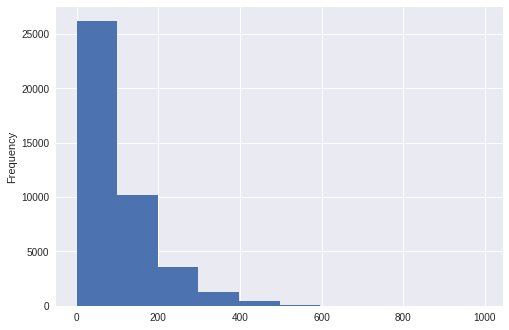

In [164]:
df['pm2.5'].plot.hist();

In [165]:
import numpy as np
df['pm2.5'].dropna().apply(np.log).plot.hist();

ValueError: ignored

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

In [0]:
','.join(['1', '2', '3'])
# import csv

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Pretend R code

```
ols1 <- lm(y ~ x1 + x2 + (x1 * x1))
summary(ols1)
```

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00272/SkillCraft1_Dataset.csv')
df.head()

In [0]:
df.shape

In [0]:
df.isna().sum()

In [0]:
import numpy as np
df = df.replace('?', np.nan)
df.isna().sum()

In [0]:
# Quinn's cleaning code
hasna = ['Age', 'HoursPerWeek', 'TotalHours']

for feat in hasna:
   df[feat] = pd.to_numeric(df[feat])
#df[hasna].head()

In [0]:
df.describe()

In [0]:
df.dtypes

In [0]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df['APM']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

In [0]:
df.LeagueIndex.value_counts()

In [0]:
# Let's say we want to answer "What are the fastest 10% of SC players like?"
# That means quantile regression with q=0.9

# First we need a formula, with our friend twiddle
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary()

In [0]:
quant_reg.predict(X)[:10]

In [0]:
linear_reg.predict(X)[:10]

In [0]:
df.TotalHours.value_counts()

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotnine as pn

In [68]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [69]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [70]:
bwt_df.describe(percentiles = [.10,  .20, .30, .75, .25, .90 ])

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
10%,97.000000,262.000000,0.000000,20.000000,61.000000,105.000000,0.000000
20%,104.000000,270.000000,0.000000,22.000000,62.000000,111.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
30%,111.000000,274.000000,0.000000,23.000000,63.000000,117.000000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000


In [71]:
# TODO - your work here! Also, add text cells for written questions.
bwt_df.shape

(1174, 7)

In [72]:
bwt_df.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [73]:
bwt_df = bwt_df.replace('?', np.nan)
bwt_df.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [74]:
bwt_df.dtypes

bwt          int64
gestation    int64
parity       int64
age          int64
height       int64
weight       int64
smoke        int64
dtype: object

In [75]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2579534937842991

In [76]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.4439783392634531
parity -3.327199613351645
age -0.008950305361154154
height 1.1540203642500357
weight 0.05016502707680326
smoke -8.40073348432133


In [0]:
bwt_df.gestation.value_counts()

In [78]:
# Let's say we want to answer "What are the lowest 10% of baby weight?"
# That means quantile regression with q=0.1

# First we need a formula, with our friend twiddle
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.1)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1809
Model:                       QuantReg   Bandwidth:                       5.762
Method:                 Least Squares   Sparsity:                        83.56
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        07:13:50   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -74.8112     25.978     -2.880      0.004    -125.779     -23.843
gestation      0.4524      0.072      6.293      0.000       0.311       0.594
parity        -3.2473      1.891     -1.717      0.086      -6.958       0.463
age           -0.1040      0.141     -0.738      0.461      -0.381       0.173
height         0.8516      0.345      2.466      0.014       0.174       1.529
weight         0.0106      0.041      0.259      0.795      -0.070       0.091
smoke        -10.2567      1.511     -6.787      0.000     -13.222      -7.292
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
quant_reg.predict(X)[:10]

0    104.736299
1    105.282755
2     93.976041
3     98.514522
4    105.774763
5     86.844011
6     90.487030
7    107.472543
8    104.743519
9    140.372528
dtype: float64

In [80]:
linear_reg.predict(X)[:10]

array([122.003102  , 125.12526017, 114.43404265, 119.77444056,
       122.5578041 , 108.10313871, 110.19241017, 125.49501999,
       126.65721512, 159.67707346])

In [0]:
bwt_df.gestation.value_counts()

In [0]:
#bwt_df['Old_first_time'] = bwt_df[['age', 'parity']].apply(lambda a: 0 if a[0] > 40 and a[1] == 1 else 1, axis=1)
#bwt_df[bwt_df.Old_first_time == 0].head()
#bwt_df.head()

In [0]:
#y2 = bwt_df.bwt.quantile(np.linspace(.00001, .90), 'lower')
#print(y2)

In [0]:
#bwt_df['age_per_weight'] = np.divide(bwt_df.age, bwt_df.weight)
#bwt_df['age_per_weight']

In [82]:
bwt_df['metric_height'] = bwt_df['height'] / 39.370
bwt_df['metric_weight'] = bwt_df['weight'] / 2.2046
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,metric_height,metric_weight
0,120,284,0,27,62,100,0,1.574803,45.359702
1,113,282,0,33,64,135,0,1.625603,61.235598
2,128,279,0,28,64,115,1,1.625603,52.163658
3,108,282,0,23,67,125,1,1.701803,56.699628
4,136,286,0,25,62,93,0,1.574803,42.184523


In [83]:
bwt_df['BMI'] = bwt_df['metric_weight'] / (bwt_df['metric_height']**2) 
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,metric_height,metric_weight,BMI
0,120,284,0,27,62,100,0,1.574803,45.359702,18.290166
1,113,282,0,33,64,135,0,1.625603,61.235598,23.172604
2,128,279,0,28,64,115,1,1.625603,52.163658,19.739626
3,108,282,0,23,67,125,1,1.701803,56.699628,19.577689
4,136,286,0,25,62,93,0,1.574803,42.184523,17.009854


In [84]:
# First we need a formula, with our friend twiddle
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)


bwt ~ gestation + parity + age + height + weight + smoke + metric_height + metric_weight + BMI


In [85]:
#bwt_df.dtypes
bwt_df.isna().sum()

bwt              0
gestation        0
parity           0
age              0
height           0
weight           0
smoke            0
metric_height    0
metric_weight    0
BMI              0
dtype: int64

In [86]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke,metric_height,metric_weight,BMI
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971,1.626858,58.277558,22.000533
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176,0.064163,9.405009,3.224001
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000,1.346203,39.462941,15.662152
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000,1.574803,51.823460,19.935935
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000,1.625603,56.699628,21.284466
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000,1.676403,63.049986,23.344253
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000,1.828804,113.399256,40.350894


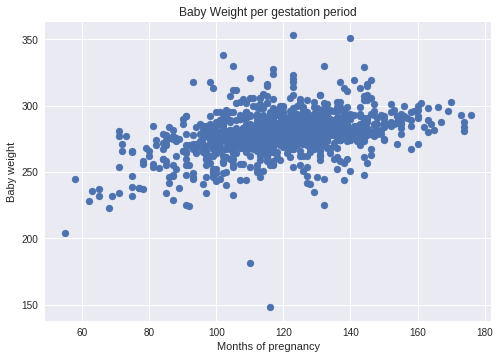

In [87]:
plt.scatter(bwt_df.bwt, bwt_df.gestation)
plt.ylabel("Baby weight")
plt.xlabel("Months of pregnancy")
plt.title("Baby Weight per gestation period")
plt.show()

In [88]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.4439783392634531
parity -3.327199613351645
age -0.008950305361154154
height 1.1540203642500357
weight 0.05016502707680326
smoke -8.40073348432133


In [89]:
bwt_drop_df = bwt_df.drop('metric_height', axis='columns')
bwt_drop_df.head()

,bwt,gestation,parity,age,height,weight,smoke,metric_weight,BMI
0,120,284,0,27,62,100,0,45.359702,18.290166
1,113,282,0,33,64,135,0,61.235598,23.172604
2,128,279,0,28,64,115,1,52.163658,19.739626
3,108,282,0,23,67,125,1,56.699628,19.577689
4,136,286,0,25,62,93,0,42.184523,17.009854


In [90]:
bwt_drop_df = bwt_drop_df.drop('metric_weight', axis='columns')
bwt_drop_df.head()

,bwt,gestation,parity,age,height,weight,smoke,BMI
0,120,284,0,27,62,100,0,18.290166
1,113,282,0,33,64,135,0,23.172604
2,128,279,0,28,64,115,1,19.739626
3,108,282,0,23,67,125,1,19.577689
4,136,286,0,25,62,93,0,17.009854


In [91]:
# First we need a formula, with our friend twiddle
quant_formula2 = 'bwt ~ ' + ' + '.join(bwt_drop_df.drop('bwt', axis='columns').columns)
print(quant_formula2)

bwt ~ gestation + parity + age + height + weight + smoke + BMI


In [184]:
# From Daniel
quant_mod = smf.quantreg(quant_formula2, data=bwt_drop_df)
quant_reg = quant_mod.fit(q=.1)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1809
Model:                       QuantReg   Bandwidth:                       5.764
Method:                 Least Squares   Sparsity:                        83.02
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        08:35:13   Df Residuals:                     1166
                                        Df Model:                            7
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -119.9695    113.567     -1.056      0.291    -342.789     102.850
gestation      0.4471      0.071      6.319      0.000       0.308       0.586
parity        -3.1010      1.887     -1.644      0.101      -6.803       0.601
age           -0.0791      0.141     -0.561      0.575      -0.356       0.198
height         1.5835      1.759      0.900      0.368      -1.868       5.035
weight        -0.1700      0.415     -0.410      0.682      -0.984       0.644
smoke        -10.4433      1.502     -6.953      0.000     -13.390      -7.496
BMI            1.0175      2.401      0.424      0.672      -3.693       5.728
==============================================================================

The condition number is large, 5.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
# dont run this cell, just for reference
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

quant_mod = smf.quantreg(quant_formula2, data=bwt_df)
quant_reg = quant_mod.fit(q=.1)
quant_reg.summary()

mod = quant_mod
res = quant_reg

In [185]:

quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = quant_mod.fit(q=q)
    return [q, quant_reg.params['Intercept'], quant_reg.params['gestation']] + \
            quant_reg.conf_int().loc['gestation'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('bwt ~ gestation', bwt_df).fit()
ols_ci = ols.conf_int().loc['gestation'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['gestation'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q           a         b        lb        ub
0  0.05 -119.969468  0.447114  0.308296  0.585933
1  0.15 -119.969468  0.447114  0.308296  0.585933
2  0.25 -119.969468  0.447114  0.308296  0.585933
3  0.35 -119.969468  0.447114  0.308296  0.585933
4  0.45 -119.969468  0.447114  0.308296  0.585933
5  0.55 -119.969468  0.447114  0.308296  0.585933
6  0.65 -119.969468  0.447114  0.308296  0.585933
7  0.75 -119.969468  0.447114  0.308296  0.585933
8  0.85 -119.969468  0.447114  0.308296  0.585933
9  0.95 -119.969468  0.447114  0.308296  0.585933
{'a': -10.754138914450326, 'b': 0.46655687694921555, 'lb': 0.40664351443120883, 'ub': 0.5264702394672223}


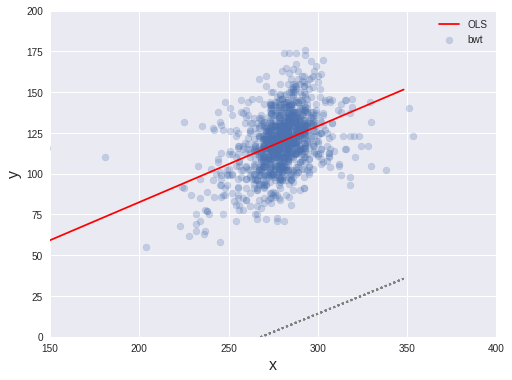

In [186]:
w = np.arange(bwt_df.gestation.min(), bwt_df.gestation.max(), 50)
get_y = lambda a, b: a + b * w

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    d = get_y(models.a[i], models.b[i])
    ax.plot(w, d, linestyle='dotted', color='grey')
    
d = get_y(ols['a'], ols['b'])

ax.plot(w, d, color='red', label='OLS')
ax.scatter(bwt_df.gestation, bwt_df.bwt, alpha=.25)
ax.set_xlim((150, 400))
ax.set_ylim((0, 200))
legend = ax.legend()
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16);

In [93]:
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,metric_height,metric_weight,BMI
0,120,284,0,27,62,100,0,1.574803,45.359702,18.290166
1,113,282,0,33,64,135,0,1.625603,61.235598,23.172604
2,128,279,0,28,64,115,1,1.625603,52.163658,19.739626
3,108,282,0,23,67,125,1,1.701803,56.699628,19.577689
4,136,286,0,25,62,93,0,1.574803,42.184523,17.009854


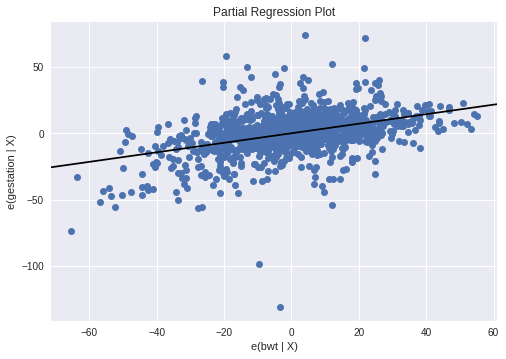

In [95]:
# Just trying some graphing to get a feel for what is possible and what might work here. 
# This isnt it, I have no idea what this is...
import statsmodels.api as sm
sm.graphics.plot_partregress('gestation', 'bwt', ['age', 'BMI'], data=bwt_drop_df, obs_labels=False);

Text(22.200000000000003, 0.5, 'gestation')

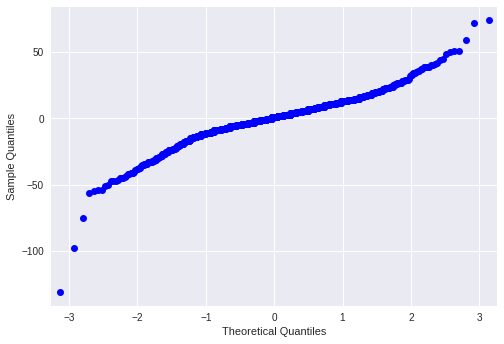

In [35]:
# Just trying some graphing to get a feel for what is possible and what might work here. 
# This isnt it, I have no idea what this is...
bwt_df.bwt = sm.add_constant(bwt_df.bwt)
mod_fit = sm.OLS(bwt_df.gestation, bwt_df.bwt).fit()
res = mod_fit.resid # residuals
fig = sm.qqplot(res)
ax.set_xlabel('baby weight', fontsize=16)
ax.set_ylabel('gestation', fontsize=16)
#plt.show()

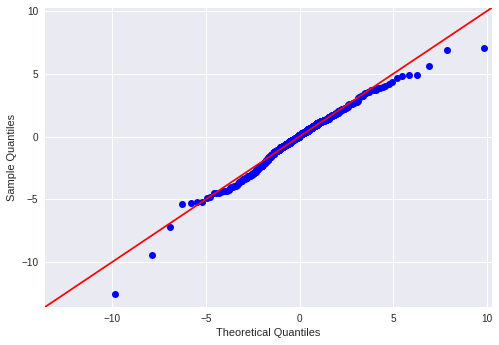

In [36]:
import scipy.stats as stats
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [37]:
stats.percentileofscore([1, 2, 3, 4], 3)

75.0

In [96]:
bwt_drop_df.quantile(.1)

bwt           97.000000
gestation    262.000000
parity         0.000000
age           20.000000
height        61.000000
weight       105.000000
smoke          0.000000
BMI           18.838871
Name: 0.1, dtype: float64

In [0]:
bwt_df['bwt']

In [0]:
!pip install plotnine

In [0]:
import plotnine as pn

In [0]:
pn.geom_qq_line?

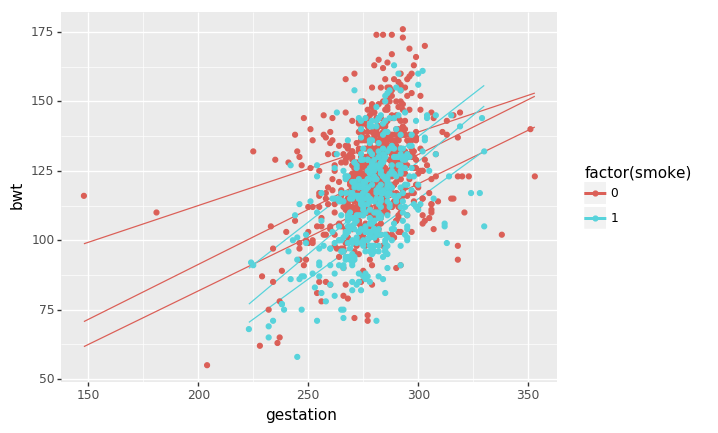

<ggplot: (-9223363270316436820)>

In [192]:
# This is the plot of the original data split on smoker or non-smoker, with quantiles at 25%, 50%, 75%
test_plot = pn.ggplot(data=bwt_drop_df, mapping=pn.aes(x='gestation', y='bwt', color='factor(smoke)'))
#test_quantile = pn.geom_point(quantiles = (0.1, 0.5, 0.9))
#test_plot + pn.geom_point(quantiles = c(0.1, 0.5, 0.9))
test_plot + pn.geom_quantile() + pn.geom_point() 
#test_plot + test_quantile + pn.geom_point()

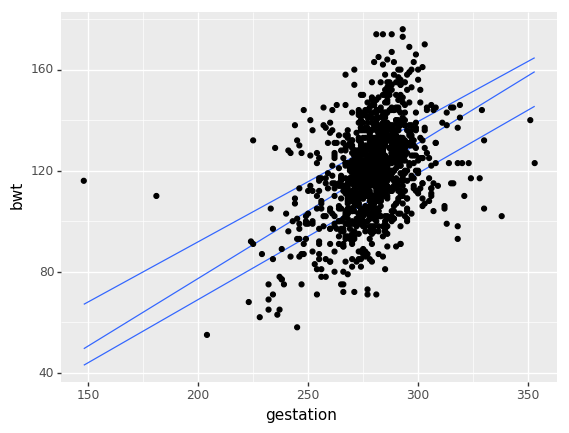

<ggplot: (-9223363270316857428)>

In [215]:
# This is the plot of the original data all together, with quantiles at 25%, 50%, 75%
plot_test2 = pn.ggplot(data=bwt_drop_df, mapping=pn.aes(x='gestation', y='bwt'))
plot_test2 + pn.geom_quantile() + pn.geom_point()


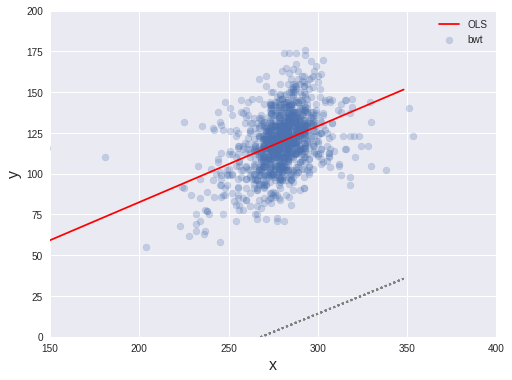

In [218]:
w = np.arange(bwt_drop_df.gestation.min(), bwt_drop_df.gestation.max(), 50)
get_y = lambda a, b: a + b * w

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    d = get_y(models.a[i], models.b[i])
    ax.plot(w, d, linestyle='dotted', color='grey')
    
d = get_y(ols['a'], ols['b'])

ax.plot(w, d, color='red', label='OLS')
ax.scatter(bwt_drop_df.gestation, bwt_drop_df.bwt, alpha=.25)
ax.set_xlim((150, 400))
ax.set_ylim((0, 200))
legend = ax.legend()
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16);

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model